
# Energy Demand Forecasting with Granite Timeseries - Few-shot Fine-tuning and Evaluation

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

In this recipe, we move beyond Zero-shot prediction to Few-shot prediction using Fine-tuning. We use a real-world dataset containing energy demand data from Spain.

## Setting Up

### Install the TSFM Library 

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here we retrieve and install a tested version of the library.

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.10" -U

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function.


In [12]:
import pandas as pd
import os
import math

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from transformers import EarlyStoppingCallback, Trainer, TrainingArguments

from tsfm_public import (
    TinyTimeMixerForPrediction,
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

### Specify configuration variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [3]:
timestamp_column = "time"
target_columns = ["total load actual"]

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"
model_context_length = 512 # the max context length for the 512-96 model
model_forecast_length = 96 # the max forecast length for the 512-96 model

# Return this percent of the original dataset when getting train/test splits.
fewshot_fraction = 0.05

# Output directory for writing evaluation results.
OUT_DIR = "/tmp/ttm_results"

## Preparing the Data

### Download the data

We'll work with a dataset of hourly electrical demand, generation by type, prices, and weather in Spain.

1. Download the energy_data.csv.zip [dataset file from Kaggle here.](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)
2. Edit the `DATA_FILE_PATH` below to point to the data file.


In [4]:
DATA_FILE_PATH = "~/Downloads/energy_dataset.csv.zip"

### Read in the data

We parse the CSV into a pandas dataframe, filling in any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a UTC datetime.

In [5]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(
  DATA_FILE_PATH,
)
# Ensure the timestamp column is a UTC datetime.
input_df[timestamp_column] = pd.to_datetime(input_df[timestamp_column], utc=True)

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Only use the last `context_length` rows for prediction.
# input_df = input_df.iloc[-model_context_length:,]

# Show the last few rows of the dataset.
input_df.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 18:00:00+00:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 19:00:00+00:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 20:00:00+00:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 21:00:00+00:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 22:00:00+00:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


### Plot a segment of the target series

Here we inspect a preview of the target time series.

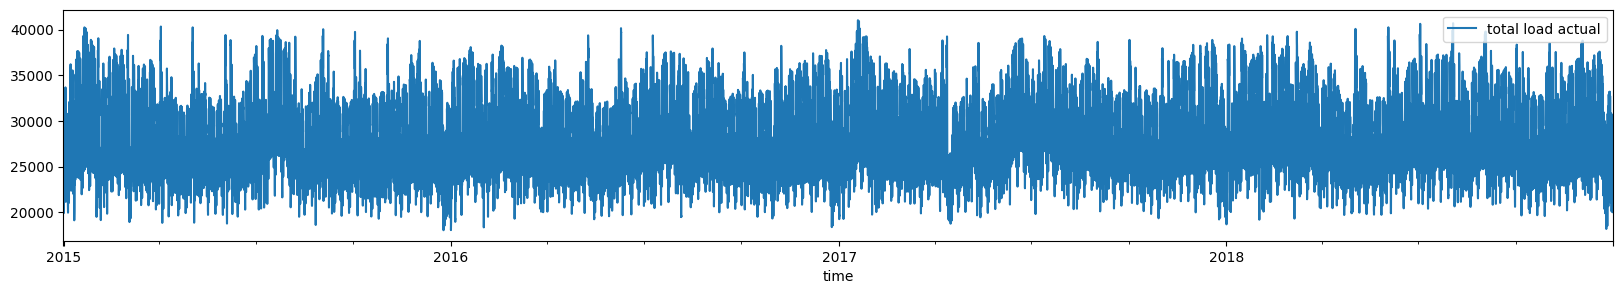

In [6]:
for target_column in target_columns:
  input_df.plot(x=timestamp_column, y=target_column, figsize=(20, 3))


## Preprocessing the Data

### Split the data into training and testing sets

We split the data into a training set and a test set using the `train_test_split` function from scikit-learn. The training set is used to train the preprocessor, while the test set is used to evaluate its performance.

In [7]:
# Configure the sizes of the splits.
chunk_length = len(input_df) // 20
start = 0
train_end = start + chunk_length * 12
valid_end = train_end + chunk_length * 4
test_end = valid_end + chunk_length * 4

split_config = {
    "train": [0, train_end],
    "valid": [train_end, valid_end],
    "test": [valid_end, test_end],
}

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=model_context_length,
    prediction_length=model_forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, input_df, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 931, val = 6917, test = 6917


## Fine-tuning the Model

### Load the model for finetuning
The TTM model is hosted on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is retrieved by the wrapper, `TinyTimeMixerForPrediction`. We have one input channel in this example.

In [8]:
# Instantiate the model.
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
  "ibm-granite/granite-timeseries-ttm-v1", # Name of the model on HuggingFace.
  num_input_channels=len(target_columns), # Number of input columns.
  head_dropout=0.7,
)

### Freeze the TTM Backbone

In [9]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


### Set up a Trainer for Finetune Few-shot 5%

Configure a Trainer for use in fine-tuning and evaluating the model. 

In [ ]:
# Important parameters
learning_rate = 0.001
num_epochs = 1  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

### Train the Model

This takes about 2 minutes.

In [ ]:
# Fine tune
finetune_forecast_trainer.train()

### Evaluate the Model

Evaluate the fine-tuned model on the test dataset.

In [ ]:
finetune_forecast_trainer.evaluate(test_dataset)

### Plot the Predictions vs. Actuals

Plot the predictions vs. actuals for some random samples of time intervals in test dataset.

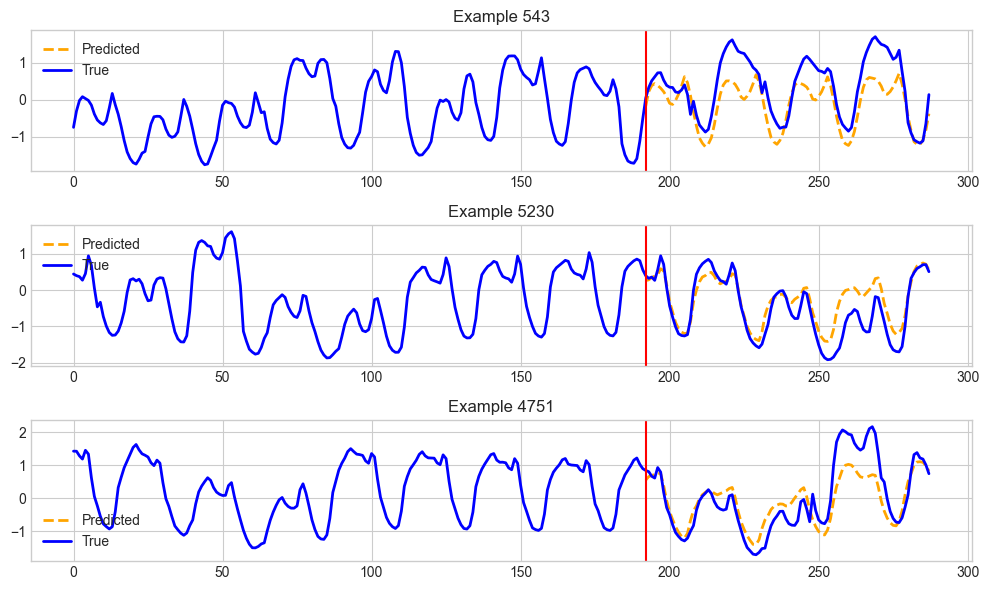

In [14]:
# plot
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "ettm2"),
    plot_prefix="test_zeroshot",
    channel=0,
    num_plots=3,
)

## Making the Forecast

### Create a forecasting pipeline with the fine-tuned model

Set up the forecasting pipeline with the model, setting `frequency` given our knowledge of the sample frequency. In this example we set `explode_forecasts` to `True`, which will format the output for plotting the history and prediction period. We then make a forecast on the dataset.

In [15]:
historical_df = input_df.iloc[-model_context_length:] 

# Create a pipeline.
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_trainer.model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=True,
    freq="h",
    device="cpu", # Specify your local GPU or CPU.
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(historical_df)
zeroshot_forecast.tail()

,time,total load actual_prediction
91,2019-01-04 18:00:00+00:00,31758.371094
92,2019-01-04 19:00:00+00:00,31979.880859
93,2019-01-04 20:00:00+00:00,31448.837891
94,2019-01-04 21:00:00+00:00,29770.250000
95,2019-01-04 22:00:00+00:00,27743.011719


### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern and an upward trend.

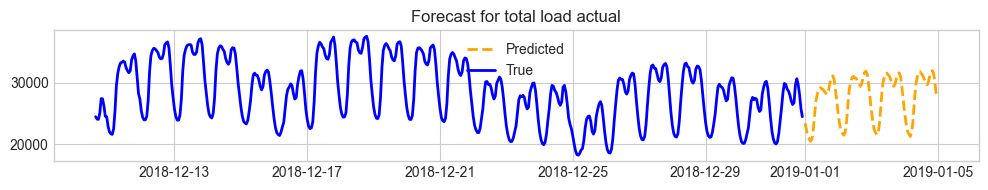

In [16]:
# Plot the historical data and predicted series.
plot_predictions(
    input_df=historical_df,
    exploded_predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[-1],
    num_plots=1,
)

## Links
* Library: [Granite TSFM on Github](https://github.com/ibm-granite/granite-tsfm)
* Model: [TinyTimeMixer on HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1)
* Dataset: [Hourly Energy Demand Generation and Weather on Kaggle](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)